In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch 
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 

In [3]:
df = pd.read_csv('C:/Users/chaeh/bigcon/dataset/0910 착과수_컬럼추가.csv') #착과수

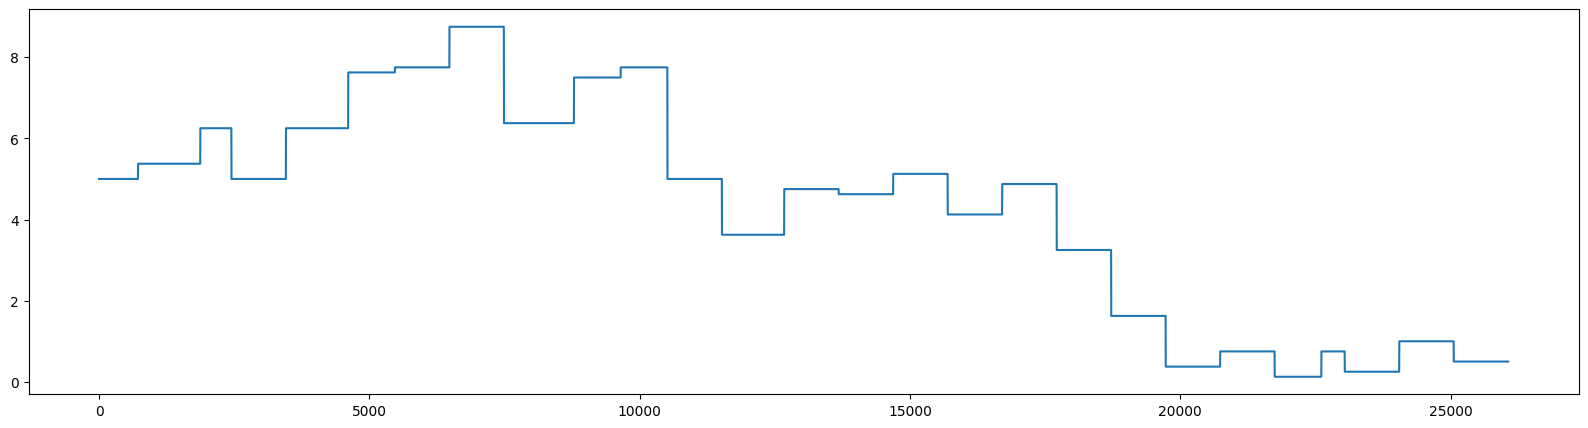

In [4]:
#착과수 추이
plt.figure(figsize=(20,5))
plt.plot(range(len(df)), df["FRST_TREE_CNT"])
plt.show()

In [5]:
df.head()

,STRG_DT,FRST_TREE_CNT,PFBS_NTRO_CBDX_CTRN,EXTN_TPRT,ABSLT_HMDT,EXTN_SRQT,WATER_LACK_VL,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
0,2022-01-01 0:00,5.0,456,-2.2,8.3,0,0.9,30.6,9.0,10.0,92.0,0,1.35
1,2022-01-01 0:10,5.0,459,-2.2,8.6,0,0.8,37.2,9.0,10.3,92.0,0,1.35
2,2022-01-01 0:20,5.0,468,-2.2,8.6,0,0.9,34.8,9.0,10.5,90.2,0,1.35
3,2022-01-01 0:30,5.0,466,-2.3,8.7,0,0.7,33.6,9.0,10.4,91.4,0,1.35
4,2022-01-01 0:40,5.0,467,-2.3,8.7,0,0.6,33.4,9.0,10.1,95.1,0,1.35


In [6]:
df = df.drop(columns=['EXTN_TPRT', 'ABSLT_HMDT', 'EXTN_SRQT', 'WATER_LACK_VL'])

In [7]:
df.shape

(26064, 9)

In [8]:
df.columns

Index(['STRG_DT', 'FRST_TREE_CNT', 'PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1',
       'HTNG_TPRT_1', 'SPL_TPRT_2', 'AVE_INNER_HMDT_1_2',
       'SKLT_OPDR_RATE_1_RIGHT', 'GDD'],
      dtype='object')

In [9]:
torch.manual_seed(0) #학습을 다시 수행 시 실헙을 동일하게 진행하기 위해서 난수를 동일하게 생성

In [10]:
# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# 파라미터 초기화
seq_length = 144 #6*24 -> 하루 단위
data_dim = 8 #전체 feature 개수
hidden_dim = 10
output_dim = 1
learning_rate = 0.001 
epochs = 500
batch_size = 128

In [12]:
#학습 데이터 셋 생성
def make_dataset(data, seq_len):
    data_X = []
    data_Y = []
    
    #sequence 데이터 생성
    for i in range(len(data)-seq_len):
        x = data[i:i+seq_len, :] #0~143, 1~144, ...
        y = data[i+seq_len, [-1]] #0~143, 1~144, ...
        data_X.append(x)
        data_Y.append(y)
    
    return np.array(data_X), np.array(data_Y)

#필요한 컬럼만 선택
df = df[['PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1', 'HTNG_TPRT_1',
       'SPL_TPRT_2', 'AVE_INNER_HMDT_1_2', 'SKLT_OPDR_RATE_1_RIGHT', 'GDD', 'FRST_TREE_CNT']]

#train/test 분리
train_size = int(len(df)*0.8) #하반기 0.2
train_set = df[0:train_size]
test_set = df[train_size:] #train_size - seq_length

In [13]:
#scaling
train_set = train_set.copy() #deepcopy 원리
test_set = test_set.copy()

scaler_x = StandardScaler()
scaler_x.fit(train_set.iloc[:,:-1])

train_set.iloc[:,:-1] = scaler_x.transform(train_set.iloc[:,:-1])
test_set.iloc[:,:-1] = scaler_x.transform(test_set.iloc[:,:-1])

scaler_y = StandardScaler()
scaler_y.fit(train_set.iloc[:,[-1]])

train_set.iloc[:,-1] = scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:,-1] = scaler_y.transform(test_set.iloc[:,[-1]])

trainX, trainY = make_dataset(np.array(train_set), seq_length) #sequence 데이터로 생성
testX, testY = make_dataset(np.array(test_set), seq_length)

In [14]:
#사용하는 device로 적용, numpy를 tensor로 바꾸기 
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)

testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

#TensorDataset은 학습 데이터 X와 레이블 Y를 묶어 놓은 컨테이너
dataset = TensorDataset(trainX_tensor, trainY_tensor)

#DataLoader를 통해 배치 크기, 데이터를 섞을지 등을 결정한다.
#참고) drop_last: batch_size에 따라 마지막 batch의 길이가 달라질 수 있어서, 마지막 배치를 사용할지 여부
dataloader = DataLoader(dataset, batch_size = batch_size, 
                        shuffle = False, drop_last = True) 

### modeling

In [15]:
#LSTM 만들기

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_length, output_dim, layers): 
        super(LSTMModel, self).__init__()
        
        self.output_dim = output_dim
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        #self.input_dim = input_dim
        
        #참고) batch_first: True이면 Output 값의 사이즈는 (batch, seq, feature)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)
    

    def reset_hidden_state(self):
        #hidden state 초기화 함수
        #매번 새로운 학습을 하여 최적의 값을 찾기 위해서 사용
        self.hidden = (
        torch.zeros(self.layers, self.seq_length, self.hidden_dim),
        torch.zeros(self.layers, self.seq_length, self.hidden_dim)
        )
        
        
    def forward(self,x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])

        return out

In [16]:
LSTM = LSTMModel(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)

In [17]:
#training
def train_LSTM(model, train_df, epochs, lr, verbose, patience):
    
    #손실함수 지정
    criterion = nn.MSELoss().to(device)
    
    #최적화
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    #에포크마다 loss 저장하기
    train_hist = np.zeros(epochs) #epoch 크기의 배열을 생성해 각 epoch마다 loss 저장
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples
            
            #seq별 hidden state reset
            model.reset_hidden_state()
            
            #h(x) 계산
            outputs = model(x_train)
            
            #cost 계산
            loss = criterion(outputs, y_train)
            
            #참고: 파이토치에서 역전파 수행 시 계속 값을 더해주기 때문에,
            #역전파 수행 전 gradients를 0으로 만들어주고 시작해야 한다.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
        train_hist[epoch] = avg_cost
        
        if epoch%verbose == 0:
            print("Epoch: ", "%04d" %(epoch),
                 'train loss: ', '{:.4f}'.format(avg_cost))
            
        #patience마다 early stopping 여부 확인
        #참고) early stopping: 더 이상 개선이 없으면 학습을 중단한다. overfitting 방지
        if (epoch%patience == 0) & (epoch !=0):
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                break
                
    return model.eval(), train_hist

In [18]:
model, train_hist = train_LSTM(LSTM, dataloader, epochs = epochs, 
                               lr = learning_rate, verbose = 20, patience = 20)

Epoch:  0000 train loss:  0.6093
Epoch:  0020 train loss:  0.0021
Epoch:  0040 train loss:  0.0010
Epoch:  0060 train loss:  0.0007
Epoch:  0080 train loss:  0.0007

 Early Stopping


In [19]:
with torch.no_grad(): #gradient 누적 방지 
    pred = []
    for i in range(len(testX_tensor)):
        model.reset_hidden_state()
        
        predicted = model(torch.unsqueeze(testX_tensor[i], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)
        
    #scaling 다시 원래대로 돌리기
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))    
    testY_inverse = scaler_y.inverse_transform(testY_tensor)    


#RMSE
rmse = mean_squared_error(testY_inverse, pred_inverse)**0.5
print('RMSE score: ', rmse)

#target test
#마지막 날의 다음 날 착과수 예측해보기
#제외해도 됨
length = len(test_set)
target = np.array(test_set)[length-seq_length:]

target = torch.FloatTensor(target)
target = target.reshape([1, seq_length, data_dim])

out = model(target)
pre = torch.flatten(out).item()

pre = round(pre, 8)
pre_inverse = scaler_y.inverse_transform(np.array(pre).reshape(-1, 1))
print(pre_inverse.reshape([1])[0])

RMSE score:  0.16795106548530067
0.6425243092316837


In [20]:
pred_inverse

array([[0.71173921],
       [0.70180833],
       [0.69997133],
       ...,
       [0.63781667],
       [0.64082297],
       [0.64140135]])

In [21]:
testY_inverse

array([[0.74999989],
       [0.74999989],
       [0.74999989],
       ...,
       [0.49999999],
       [0.49999999],
       [0.49999999]])

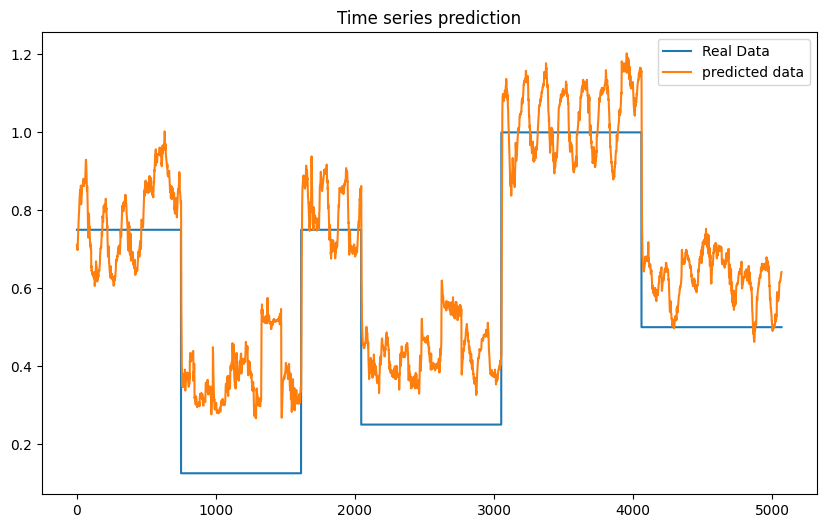

In [25]:
plt.figure(figsize = (10,6))
plt.plot(testY_inverse, label = 'Real Data')
plt.plot(pred_inverse, label = 'predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()